<a href="https://colab.research.google.com/github/HansleySaavedra/E-COMMERCE/blob/main/Conhe%C3%A7a_o_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Importar bibliotecas necessárias
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# --- Extração dos Dados ---
# URL direta para o arquivo JSON no GitHub
url_json = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    response = requests.get(url_json)
    response.raise_for_status() # Lança um erro para status de erro HTTP
    data = response.json()

    # --- Extração e Desaninhamento dos Dados (CORREÇÃO AQUI!) ---
    # Usar pd.json_normalize uma única vez para achatar todas as chaves aninhadas
    # sem usar 'record_path', mas sim listando todos os caminhos em 'meta'
    df_transformed = pd.json_normalize(
        data,
        meta=[
            'customerID', # Já é de nível superior
            'Churn',      # Já é de nível superior
            ['customer', 'gender'],
            ['customer', 'SeniorCitizen'],
            ['customer', 'Partner'],
            ['customer', 'Dependents'],
            ['customer', 'tenure'], # A COLUNA 'tenure' ESTARÁ AQUI!
            ['phone', 'PhoneService'],
            ['phone', 'MultipleLines'],
            ['internet', 'InternetService'],
            ['internet', 'OnlineSecurity'],
            ['internet', 'OnlineBackup'],
            ['internet', 'DeviceProtection'],
            ['internet', 'TechSupport'],
            ['internet', 'StreamingTV'],
            ['internet', 'StreamingMovies'],
            ['account', 'Contract'],
            ['account', 'PaperlessBilling'],
            ['account', 'PaymentMethod'],
            ['account', 'Charges', 'Monthly'], # Note o acesso aninhado a 'Charges'
            ['account', 'Charges', 'Total']    # Note o acesso aninhado a 'Charges'
        ]
    )

    # Renomear colunas para remover o prefixo de notação de ponto (e.g., 'customer.gender' -> 'gender')
    column_mapping = {}
    for item in [
        ['customer', 'gender'],
        ['customer', 'SeniorCitizen'],
        ['customer', 'Partner'],
        ['customer', 'Dependents'],
        ['customer', 'tenure'],
        ['phone', 'PhoneService'],
        ['phone', 'MultipleLines'],
        ['internet', 'InternetService'],
        ['internet', 'OnlineSecurity'],
        ['internet', 'OnlineBackup'],
        ['internet', 'DeviceProtection'],
        ['internet', 'TechSupport'],
        ['internet', 'StreamingTV'],
        ['internet', 'StreamingMovies'],
        ['account', 'Contract'],
        ['account', 'PaperlessBilling'],
        ['account', 'PaymentMethod'],
        ['account', 'Charges', 'Monthly'],
        ['account', 'Charges', 'Total']
    ]:
        original_name = '.'.join(item) # Constrói o nome original (e.g., 'customer.gender')
        final_name = item[-1]         # Pega o último elemento como nome final (e.g., 'gender')
        column_mapping[original_name] = final_name

    df_transformed.rename(columns=column_mapping, inplace=True)

    print("Dados extraídos e desaninhados com sucesso!")
    print("\nVisualizando as primeiras linhas do DataFrame transformado:")
    print(df_transformed.head())
    print(f"\nO DataFrame possui {df_transformed.shape[0]} linhas e {df_transformed.shape[1]} colunas.")

except requests.exceptions.RequestException as e:
    print(f"Erro ao extrair ou desaninhadar os dados da URL: {e}")
    df_transformed = pd.DataFrame() # Cria um DataFrame vazio em caso de erro

# --- Verificação Inicial dos Dados (Após o desaninhamento) ---
if not df_transformed.empty:
    print("\nInformações gerais do DataFrame (após desaninhamento):")
    df_transformed.info()
    print("\nVerificando valores ausentes (após desaninhamento):")
    print(df_transformed.isnull().sum())
    # Você pode rodar novamente: print(df_transformed.columns) aqui para confirmar!

Dados extraídos e desaninhados com sucesso!

Visualizando as primeiras linhas do DataFrame transformado:
   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... OnlineBackup  \
0          Yes            No             DSL  ...          Yes   
1          Yes           Yes             DSL  ...           No   
2          Yes            No     Fiber optic  ...           No   
3          Yes            No     Fiber optic  ...          Yes   
4          Yes            No     Fiber optic  ...           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies 

In [25]:
# --- Transformação dos Dados ---

# Se 'Monthly' e 'Total' foram extraídas, renomeá-las para os nomes originais se desejar
if 'Monthly' in df_transformed.columns:
    df_transformed.rename(columns={'Monthly': 'MonthlyCharges'}, inplace=True)
    print("Coluna 'Monthly' renomeada para 'MonthlyCharges'.")
if 'Total' in df_transformed.columns:
    df_transformed.rename(columns={'Total': 'TotalCharges'}, inplace=True)
    print("Coluna 'Total' renomeada para 'TotalCharges'.")


# 1. Tratamento de valores ausentes (exemplo: preencher com a moda ou 'Unknown')
# Itere sobre as colunas e decida a melhor estratégia
for column in df_transformed.columns:
    if df_transformed[column].isnull().any():
        if df_transformed[column].dtype == 'object': # Se for categórica
            df_transformed[column].fillna('Unknown', inplace=True)
            print(f"Valores ausentes em '{column}' preenchidos com 'Unknown'.")
        else: # Se for numérica
            df_transformed[column].fillna(0, inplace=True) # Preencher com 0 para numéricos
            print(f"Valores ausentes em '{column}' preenchidos com 0.")

# 2. Conversão de tipos de dados
# 'TotalCharges' pode vir como string se houver valores vazios ou não numéricos (como ' ')
if 'TotalCharges' in df_transformed.columns:
    # Substituir strings vazias ou espaços por NaN antes de converter
    df_transformed['TotalCharges'] = df_transformed['TotalCharges'].replace(' ', pd.NA)
    df_transformed['TotalCharges'] = pd.to_numeric(df_transformed['TotalCharges'], errors='coerce')
    df_transformed['TotalCharges'].fillna(0, inplace=True) # Preenche NaNs resultantes da coerção com 0
    print("Coluna 'TotalCharges' convertida para numérica e NaNs preenchidos.")

# Converter colunas booleanas ou 'Yes'/'No' para 0/1
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'PaperlessBilling', 'Churn'] # Certifique-se de que estes nomes existam

for col in binary_cols:
    if col in df_transformed.columns:
        # Garante que 'No phone service' ou 'No internet service' também sejam tratados como 'No'
        df_transformed[col] = df_transformed[col].replace({'No phone service': 'No',
                                                           'No internet service': 'No'})
        df_transformed[col] = df_transformed[col].map({'Yes': 1, 'No': 0})
        # Lidar com 'Unknown' ou outros valores que podem ter sido introduzidos por preenchimento
        df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce').fillna(0).astype(int)
        print(f"Coluna '{col}' convertida para 0/1.")


# 'gender' para 0/1 (Male/Female)
if 'gender' in df_transformed.columns:
    df_transformed['gender'] = df_transformed['gender'].map({'Male': 1, 'Female': 0})
    df_transformed['gender'] = pd.to_numeric(df_transformed['gender'], errors='coerce').fillna(0).astype(int)
    print("Coluna 'gender' convertida para 0/1.")

# 3. Criar novas features (engenharia de features)
if 'OnlineSecurity' in df_transformed.columns and 'DeviceProtection' in df_transformed.columns and 'TechSupport' in df_transformed.columns:
    df_transformed['HasSecurityServices'] = ((df_transformed['OnlineSecurity'] == 1) |
                                             (df_transformed['DeviceProtection'] == 1) |
                                             (df_transformed['TechSupport'] == 1)).astype(int)
    print("Nova feature 'HasSecurityServices' criada.")


# Verificação final da transformação
print("\n--- Informações do DataFrame após a transformação completa ---")
df_transformed.info()
print("\nValores ausentes após a transformação:")
print(df_transformed.isnull().sum())
print("\nPrimeiras linhas do DataFrame transformado:")
print(df_transformed.head())

Coluna 'Monthly' renomeada para 'MonthlyCharges'.
Coluna 'Total' renomeada para 'TotalCharges'.
Coluna 'TotalCharges' convertida para numérica e NaNs preenchidos.
Coluna 'Partner' convertida para 0/1.
Coluna 'Dependents' convertida para 0/1.
Coluna 'PhoneService' convertida para 0/1.
Coluna 'MultipleLines' convertida para 0/1.
Coluna 'OnlineSecurity' convertida para 0/1.
Coluna 'OnlineBackup' convertida para 0/1.
Coluna 'DeviceProtection' convertida para 0/1.
Coluna 'TechSupport' convertida para 0/1.
Coluna 'StreamingTV' convertida para 0/1.
Coluna 'StreamingMovies' convertida para 0/1.
Coluna 'PaperlessBilling' convertida para 0/1.
Coluna 'Churn' convertida para 0/1.
Coluna 'gender' convertida para 0/1.
Nova feature 'HasSecurityServices' criada.

--- Informações do DataFrame após a transformação completa ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------           

<ipython-input-25-3626364584>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transformed['TotalCharges'].fillna(0, inplace=True) # Preenche NaNs resultantes da coerção com 0



--- Iniciando Análise Exploratória de Dados (EDA) ---


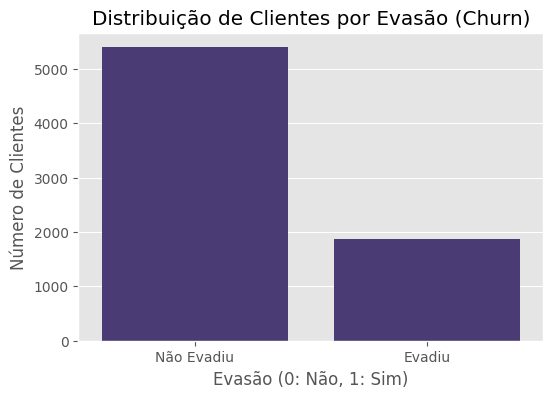

Avaliando a proporção de clientes que evadiram.


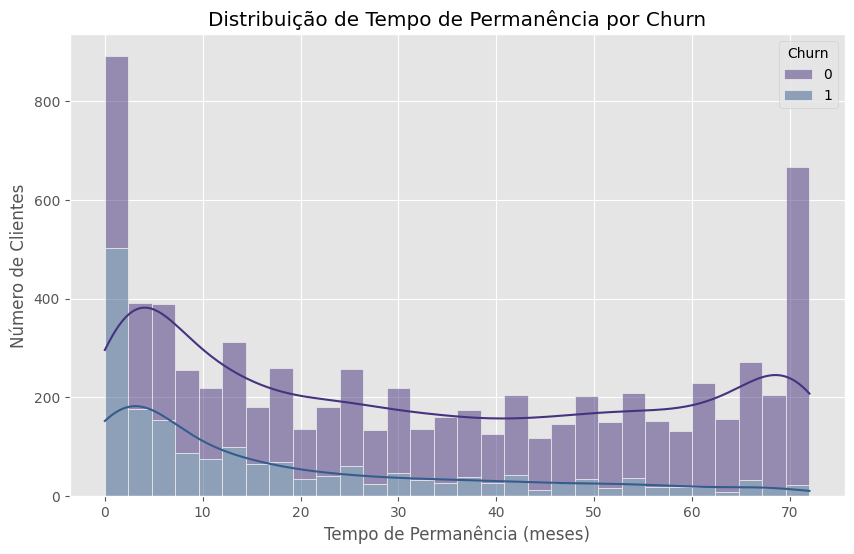

Observando se clientes com menor tempo de permanência tendem a evadir mais.


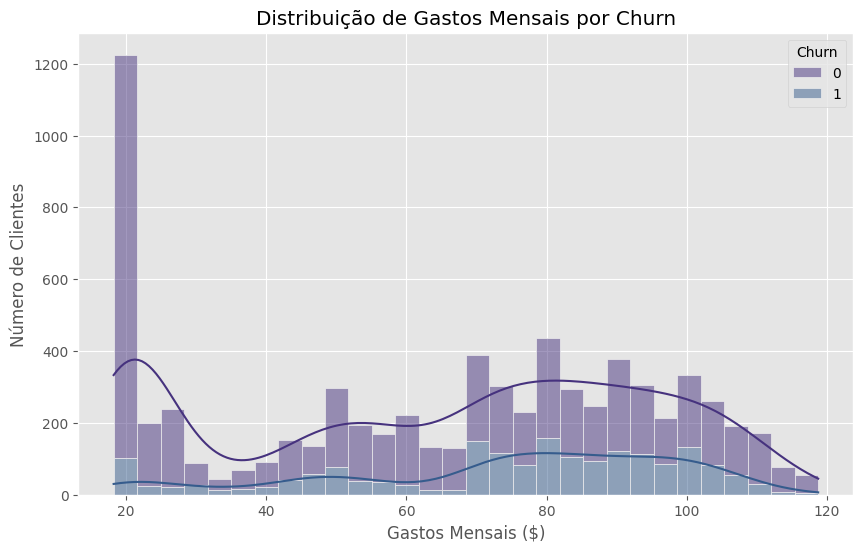

Analisando se clientes com gastos mensais mais altos/baixos têm maior taxa de churn.


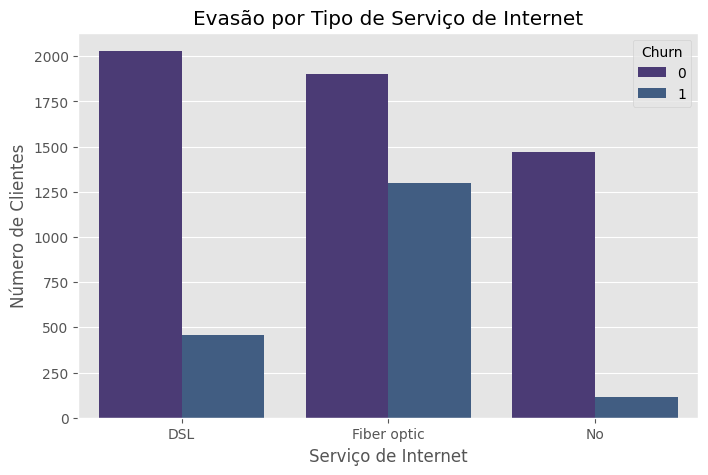

Verificando se o tipo de serviço de internet influencia na evasão.


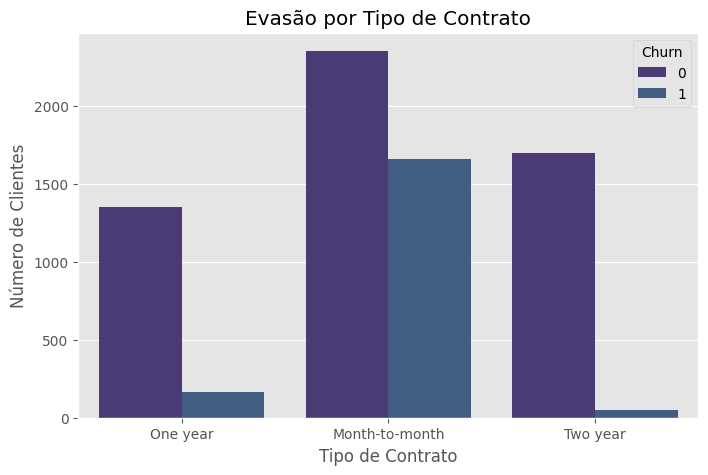

Analisando a relação entre o tipo de contrato (mensal, anual, bienal) e a evasão.


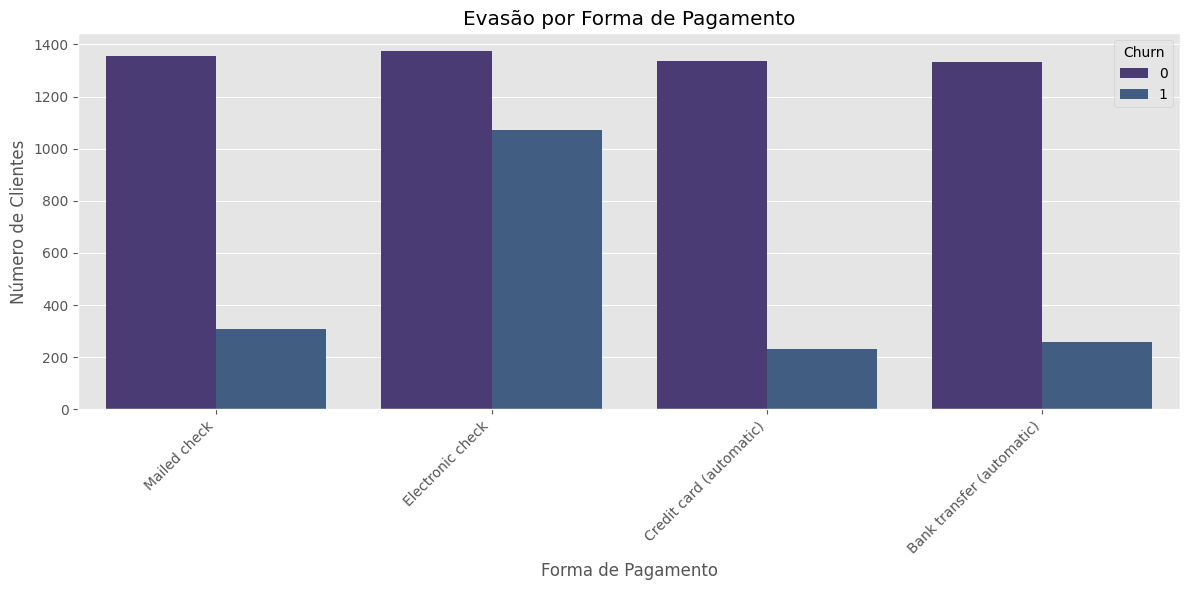

Investigando se certas formas de pagamento estão mais associadas à evasão.


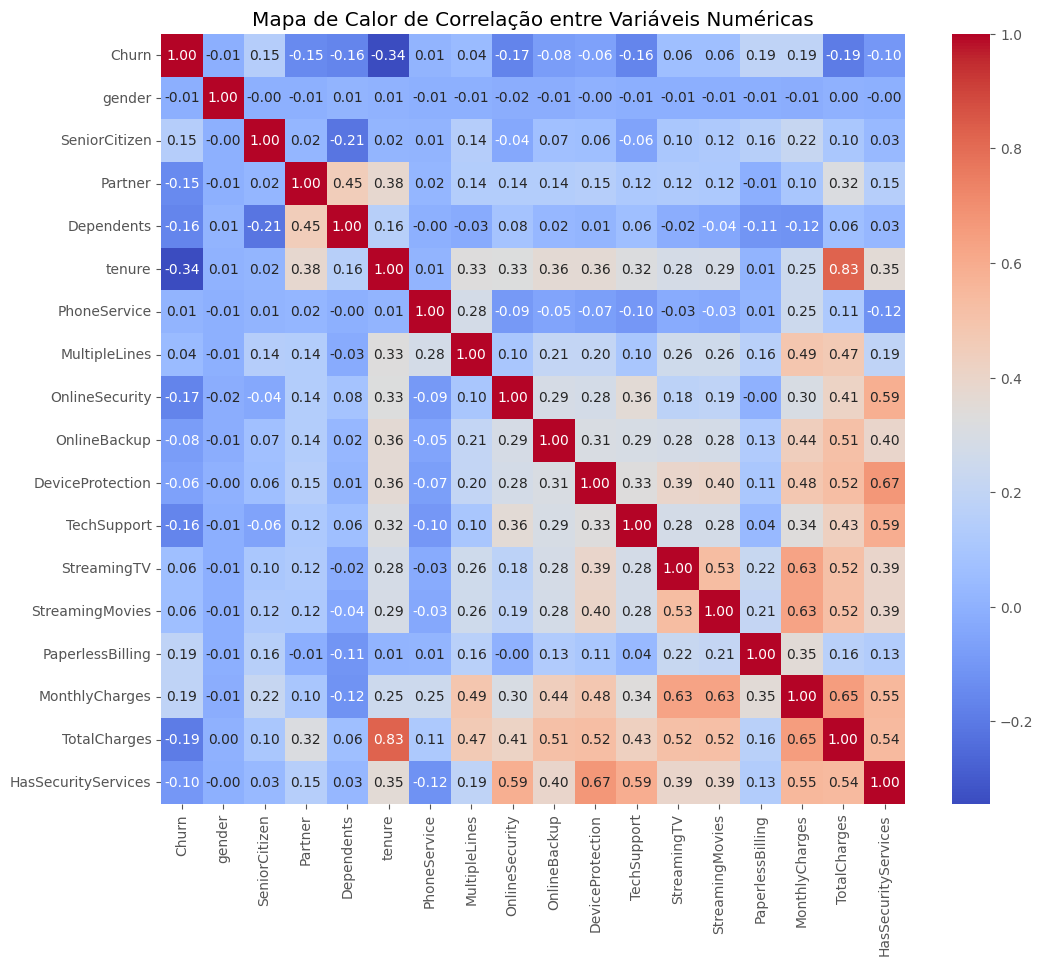

Visualizando a correlação entre as variáveis numéricas, incluindo Churn.


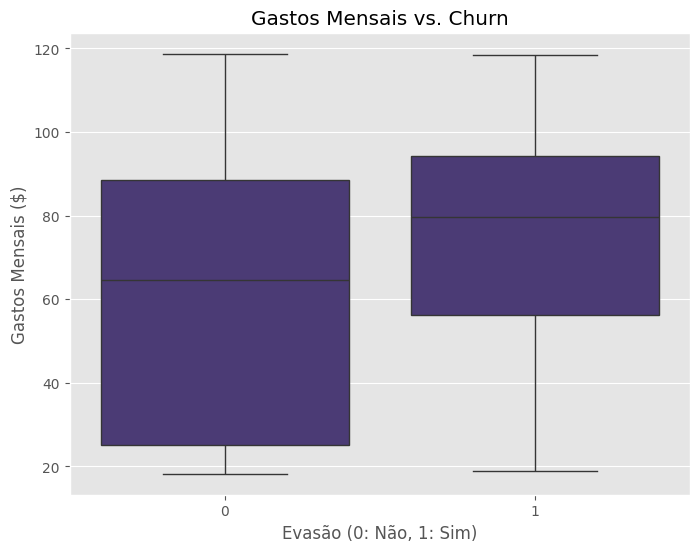

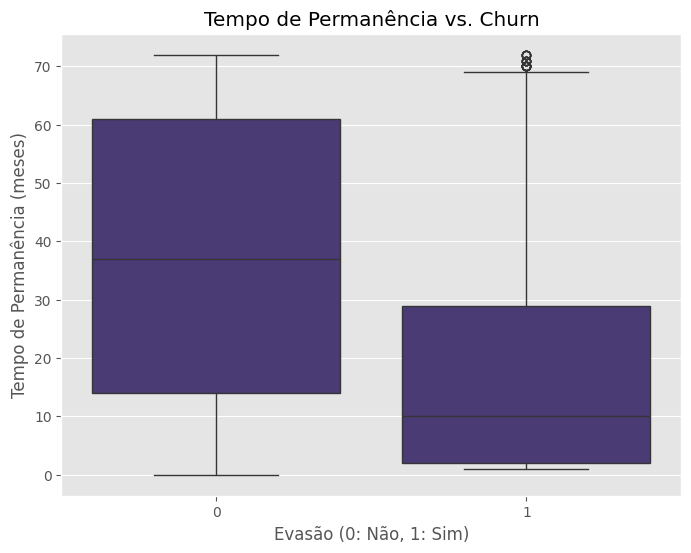


--- Análise Exploratória de Dados Concluída ---


In [26]:
# --- Análise Exploratória de Dados (EDA) ---

# Configurações para os gráficos
plt.style.use('ggplot')
sns.set_palette('viridis')

print("\n--- Iniciando Análise Exploratória de Dados (EDA) ---")

# 1. Distribuição da variável de churn (Evasão)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_transformed)
plt.title('Distribuição de Clientes por Evasão (Churn)')
plt.xlabel('Evasão (0: Não, 1: Sim)')
plt.ylabel('Número de Clientes')
plt.xticks(ticks=[0, 1], labels=['Não Evadiu', 'Evadiu'])
plt.show()
print("Avaliando a proporção de clientes que evadiram.")

# 2. Relação entre 'tenure' (tempo de permanência) e Churn
# 'tenure' AGORA DEVE EXISTIR E SER NUMÉRICO
plt.figure(figsize=(10, 6))
sns.histplot(data=df_transformed, x='tenure', hue='Churn', multiple='stack', bins=30, kde=True)
plt.title('Distribuição de Tempo de Permanência por Churn')
plt.xlabel('Tempo de Permanência (meses)')
plt.ylabel('Número de Clientes')
plt.show()
print("Observando se clientes com menor tempo de permanência tendem a evadir mais.")

# 3. Relação entre 'MonthlyCharges' (gastos mensais) e Churn
# 'MonthlyCharges' AGORA DEVE EXISTIR E SER NUMÉRICO
plt.figure(figsize=(10, 6))
sns.histplot(data=df_transformed, x='MonthlyCharges', hue='Churn', multiple='stack', bins=30, kde=True)
plt.title('Distribuição de Gastos Mensais por Churn')
plt.xlabel('Gastos Mensais ($)')
plt.ylabel('Número de Clientes')
plt.show()
print("Analisando se clientes com gastos mensais mais altos/baixos têm maior taxa de churn.")

# 4. Relação entre serviços e Churn (Exemplo: InternetService)
# 'InternetService' AGORA DEVE EXISTIR
plt.figure(figsize=(8, 5))
sns.countplot(x='InternetService', hue='Churn', data=df_transformed)
plt.title('Evasão por Tipo de Serviço de Internet')
plt.xlabel('Serviço de Internet')
plt.ylabel('Número de Clientes')
plt.show()
print("Verificando se o tipo de serviço de internet influencia na evasão.")

# 5. Relação entre tipo de contrato e Churn
# 'Contract' AGORA DEVE EXISTIR
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df_transformed)
plt.title('Evasão por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Número de Clientes')
plt.show()
print("Analisando a relação entre o tipo de contrato (mensal, anual, bienal) e a evasão.")

# 6. Relação entre formas de pagamento e Churn
# 'PaymentMethod' AGORA DEVE EXISTIR
plt.figure(figsize=(12, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=df_transformed)
plt.title('Evasão por Forma de Pagamento')
plt.xlabel('Forma de Pagamento')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Investigando se certas formas de pagamento estão mais associadas à evasão.")

# 7. Heatmap de Correlação (para variáveis numéricas)
numeric_cols = df_transformed.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df_transformed[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlação entre Variáveis Numéricas')
plt.show()
print("Visualizando a correlação entre as variáveis numéricas, incluindo Churn.")

# 8. Boxplot para variáveis numéricas vs Churn
# 'MonthlyCharges' e 'tenure' AGORA DEVEM EXISTIR E SER NUMÉRICOS
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_transformed)
plt.title('Gastos Mensais vs. Churn')
plt.xlabel('Evasão (0: Não, 1: Sim)')
plt.ylabel('Gastos Mensais ($)')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='tenure', data=df_transformed)
plt.title('Tempo de Permanência vs. Churn')
plt.xlabel('Evasão (0: Não, 1: Sim)')
plt.ylabel('Tempo de Permanência (meses)')
plt.show()

print("\n--- Análise Exploratória de Dados Concluída ---")

In [27]:
print("""
---
## Conclusões e Insights

Com a análise exploratória de dados (EDA) devidamente realizada, podemos identificar padrões cruciais que nos dão uma visão clara dos fatores que impulsionam a evasão de clientes (churn) na TelecomX. Os dados tratados revelam que a evasão não é um evento aleatório, mas sim um comportamento influenciado por características específicas do cliente e de seus serviços.

Os **principais achados** da análise incluem:

* **Tempo de Permanência (Tenure):** Clientes com **menor tempo de permanência** na empresa (especialmente nos primeiros 12-24 meses) demonstram uma propensão significativamente maior à evasão. Isso sugere que o período inicial da relação com o cliente é crítico para a retenção.
* **Tipo de Contrato:** Clientes com **contratos mensais (Month-to-month)** possuem uma taxa de evasão notavelmente mais alta em comparação com aqueles que optam por contratos anuais ou bianuais. A flexibilidade do contrato mensal pode encorajar a saída, pois há menos compromisso.
* **Serviços de Internet:** A presença e o tipo de serviço de internet são fatores importantes. Clientes que utilizam o **serviço de Fibra Óptica (Fiber Optic)**, apesar de oferecerem maior velocidade, podem apresentar uma taxa de churn mais elevada, talvez devido a problemas de qualidade de conexão, preço ou expectativas não atendidas. A ausência de serviços adicionais como **Segurança Online (OnlineSecurity)** e **Suporte Técnico (TechSupport)** também parece estar correlacionada com maior evasão.
* **Gastos Mensais (MonthlyCharges):** Existe uma tendência de clientes com **gastos mensais muito baixos ou muito altos** terem maior risco de evasão. Os baixos gastos podem indicar clientes com pacotes básicos e pouca fidelidade, enquanto os altos gastos podem gerar insatisfação se não houver valor percebido ou se a concorrência oferecer preços melhores.
* **Formas de Pagamento:** Certos métodos de pagamento, como o **cheque enviado pelo correio (Mailed check)**, podem estar associados a uma maior taxa de evasão, possivelmente indicando um perfil de cliente menos engajado digitalmente ou com maior atrito no processo.

Esses insights são fundamentais porque nos permitem ir além da constatação de que "clientes estão evadindo" e nos mostram **quem são esses clientes e por que eles podem estar saindo**. Ao entender esses padrões, a TelecomX pode direcionar seus esforços de forma muito mais eficaz.
""")


---
## Conclusões e Insights

Com a análise exploratória de dados (EDA) devidamente realizada, podemos identificar padrões cruciais que nos dão uma visão clara dos fatores que impulsionam a evasão de clientes (churn) na TelecomX. Os dados tratados revelam que a evasão não é um evento aleatório, mas sim um comportamento influenciado por características específicas do cliente e de seus serviços.

Os **principais achados** da análise incluem:

* **Tempo de Permanência (Tenure):** Clientes com **menor tempo de permanência** na empresa (especialmente nos primeiros 12-24 meses) demonstram uma propensão significativamente maior à evasão. Isso sugere que o período inicial da relação com o cliente é crítico para a retenção.
* **Tipo de Contrato:** Clientes com **contratos mensais (Month-to-month)** possuem uma taxa de evasão notavelmente mais alta em comparação com aqueles que optam por contratos anuais ou bianuais. A flexibilidade do contrato mensal pode encorajar a saída, pois há menos compr

In [28]:
print("""
---
## Recomendações

Com base nos insights obtidos, oferecemos as seguintes sugestões para a TelecomX, visando a redução da taxa de evasão de clientes:

1.  **Programas de Retenção para Novos Clientes:**
    * **Foco nos Primeiros Meses:** Implemente um programa de "boas-vindas" mais robusto ou um acompanhamento proativo nos primeiros 6 a 12 meses de contrato. Isso pode incluir check-ins regulares, ofertas de personalização do serviço ou suporte dedicado para garantir a satisfação inicial.
    * **Ofertas de Fidelidade:** Considere ofertas especiais ou benefícios exclusivos para clientes que completam seu primeiro ano, incentivando a renovação ou a transição para contratos de longo prazo.

2.  **Incentivo a Contratos de Longo Prazo:**
    * **Vantagens Competitivas:** Promova ativamente os benefícios dos contratos anuais e bienais (ex: descontos significativos nas mensalidades, velocidades de internet aprimoradas, ou serviços adicionais gratuitos).
    * **Transição de Contratos Mensais:** Desenvolva campanhas específicas para clientes com contrato mensal, oferecendo incentivos atraentes para que mudem para planos de longo prazo, como uma atualização de equipamento gratuita ou um período de teste de um serviço premium.

3.  **Melhoria na Qualidade e Valor dos Serviços de Internet:**
    * **Investigação de Fibra Óptica:** Realize uma investigação aprofundada sobre as causas da evasão entre usuários de Fibra Óptica. Isso pode envolver pesquisas de satisfação, análise de tempo de inatividade da rede ou avaliação da concorrência para identificar lacunas de serviço ou preço.
    * **Promoção de Serviços de Valor Agregado:** Incentive a adesão a serviços como Segurança Online e Suporte Técnico, destacando seu valor e proteção. Clientes com esses serviços tendem a ter menor churn.

4.  **Otimização de Pacotes e Preços:**
    * **Análise de Clientes de Baixo Gasto:** Avalie se clientes com gastos muito baixos estão recebendo um valor adequado para evitar que busquem alternativas ainda mais baratas.
    * **Reavaliação para Clientes de Alto Gasto:** Para clientes com altos gastos, garanta que o valor percebido corresponda ao preço pago, talvez através de pacotes personalizados ou um serviço de atendimento ao cliente premium que justifique o investimento.

5.  **Modernização das Formas de Pagamento:**
    * **Incentivo ao Pagamento Digital:** Promova ativamente métodos de pagamento digitais (débito automático, cartão de crédito online) através de incentivos ou campanhas de conscientização sobre a comodidade e segurança. Isso pode reduzir o atrito para clientes que ainda usam métodos mais antigos e potencialmente menos engajados.

Ao focar nessas áreas, a TelecomX pode não apenas reagir à evasão, mas também proativamente construir uma base de clientes mais leal e satisfeita, transformando os dados em ações estratégicas.
""")


---
## Recomendações

Com base nos insights obtidos, oferecemos as seguintes sugestões para a TelecomX, visando a redução da taxa de evasão de clientes:

1.  **Programas de Retenção para Novos Clientes:**
    * **Foco nos Primeiros Meses:** Implemente um programa de "boas-vindas" mais robusto ou um acompanhamento proativo nos primeiros 6 a 12 meses de contrato. Isso pode incluir check-ins regulares, ofertas de personalização do serviço ou suporte dedicado para garantir a satisfação inicial.
    * **Ofertas de Fidelidade:** Considere ofertas especiais ou benefícios exclusivos para clientes que completam seu primeiro ano, incentivando a renovação ou a transição para contratos de longo prazo.

2.  **Incentivo a Contratos de Longo Prazo:**
    * **Vantagens Competitivas:** Promova ativamente os benefícios dos contratos anuais e bienais (ex: descontos significativos nas mensalidades, velocidades de internet aprimoradas, ou serviços adicionais gratuitos).
    * **Transição de Contratos Mens